In [1]:
pip install numpy matplotlib opencv-python scikit-image numba


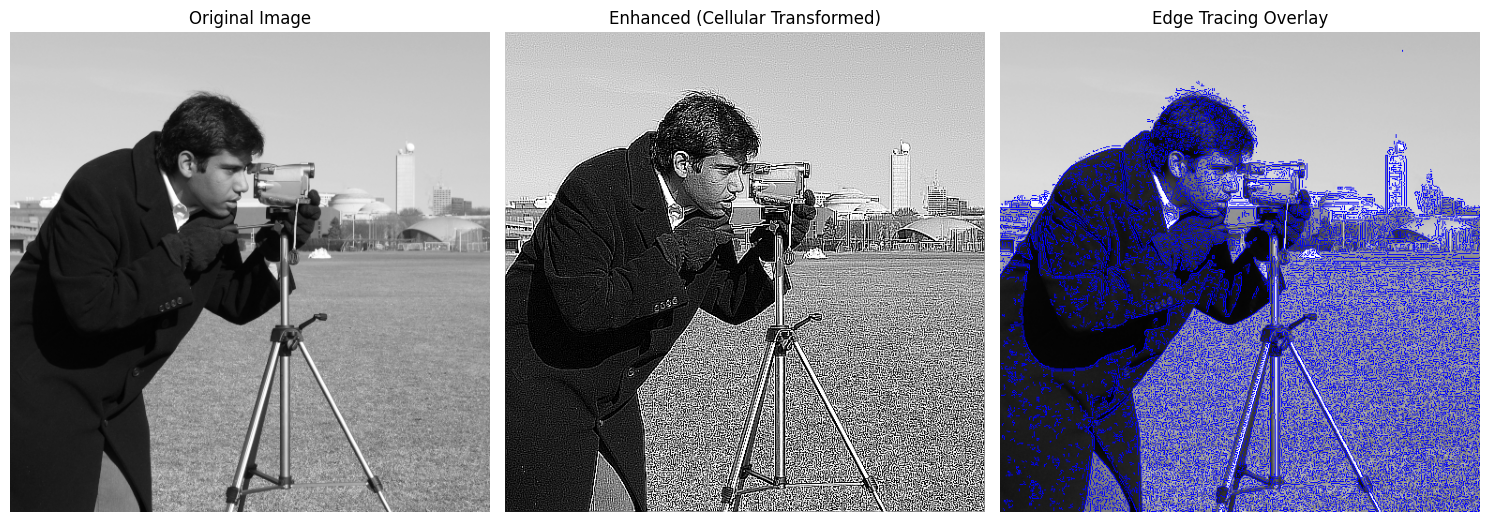

✅ Enhanced image saved as 'cellular_enhanced.png'
✅ Edge tracing saved as 'cellular_traced.png'


In [2]:
# =====================================================
# Parallel Cellular Image Transformation + Edge Tracing
# =====================================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
from numba import njit, prange
from skimage import data

# -----------------------------
# 1️⃣ Define the Cellular Update Rule
# -----------------------------
@njit(parallel=True)
def cellular_transform(img, alpha=1.2, iterations=2):
    """
    Parallel cellular image transformation (edge enhancement)
    Args:
        img: 2D grayscale image (numpy array, normalized to [0,1])
        alpha: enhancement strength
        iterations: number of iterations for evolution
    Returns:
        Transformed image
    """
    h, w = img.shape
    output = img.copy()

    for _ in range(iterations):
        new_img = output.copy()
        for i in prange(1, h - 1):
            for j in range(1, w - 1):
                # Local 3x3 neighborhood
                neighborhood = output[i-1:i+2, j-1:j+2]
                mean_neighbors = (np.sum(neighborhood) - output[i, j]) / 8.0

                # Cellular rule: enhance differences
                val = output[i, j] + alpha * (output[i, j] - mean_neighbors)

                # Clip to valid range
                if val < 0.0:
                    val = 0.0
                elif val > 1.0:
                    val = 1.0

                new_img[i, j] = val
        output = new_img
    return output


# -----------------------------
# 2️⃣ Load or Use a Sample Image
# -----------------------------
# You can replace this with your own image path:
# img = cv2.imread('your_image.jpg', cv2.IMREAD_GRAYSCALE)
# For demonstration, we'll use the built-in "camera" image
img = data.camera()
img_gray = img / 255.0  # Normalize to [0,1]

# -----------------------------
# 3️⃣ Apply Parallel Cellular Transformation
# -----------------------------
transformed = cellular_transform(img_gray, alpha=1.5, iterations=3)

# -----------------------------
# 4️⃣ Generate Edge Tracing from Transformed Image
# -----------------------------
edges = cv2.Canny((transformed * 255).astype(np.uint8), 100, 200)

# Overlay edges on original grayscale image
traced = cv2.cvtColor((img_gray * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
traced[edges > 0] = [255, 0, 0]  # Red edges

# -----------------------------
# 5️⃣ Display Results
# -----------------------------
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Enhanced (Cellular Transformed)")
plt.imshow(transformed, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Edge Tracing Overlay")
plt.imshow(cv2.cvtColor(traced, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

# -----------------------------
# 6️⃣ Save Results (optional)
# -----------------------------
cv2.imwrite("cellular_enhanced.png", (transformed * 255).astype(np.uint8))
cv2.imwrite("cellular_traced.png", traced)

print("✅ Enhanced image saved as 'cellular_enhanced.png'")
print("✅ Edge tracing saved as 'cellular_traced.png'")
